# Imports

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data Loading

In [4]:
# !git clone https://github.com/grudloff/stock_market_GAN.git

In [5]:
stock_code = "TSLA"
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2021, 12, 31)
dataframe = pdr.get_data_yahoo(stock_code, start, end)
dataframe = dataframe.reset_index()

[*********************100%***********************]  1 of 1 completed


In [6]:
dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000,2.898000e+03
mean,40.978282,41.850743,40.056747,41.012763,41.012763,9.419163e+07
std,75.207373,76.854678,73.451602,75.288572,75.288572,8.470547e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,5.680000,6.015500,5.441667,5.821833,5.821833,3.853050e+07
50%,15.380667,15.651667,15.139333,15.372666,15.372666,7.455300e+07
75%,22.205667,22.651999,21.816000,22.255000,22.255000,1.199960e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [7]:
dataframe.shape

(2898, 7)

In [8]:
def add_Ma(dataframe):
  Ma_window=5
  for i in range(0,dataframe.shape[0]-Ma_window):
    dataframe.loc[dataframe.index[i+Ma_window],'Ma'] = np.round(((dataframe.iloc[i,4]+ dataframe.iloc[i+1,4] +dataframe.iloc[i+2,4] + dataframe.iloc[i+3,4]+ dataframe.iloc[i+4,4])/5),6)
  return dataframe[5:-5]

dataframe=add_Ma(dataframe)
dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ma
5,2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500,1.399867
6,2010-07-08,1.076000,1.168000,1.038000,1.164000,1.164000,115671000,1.292000
7,2010-07-09,1.172000,1.193333,1.103333,1.160000,1.160000,60759000,1.207067
8,2010-07-12,1.196667,1.204667,1.133333,1.136667,1.136667,33037500,1.146267
9,2010-07-13,1.159333,1.242667,1.126667,1.209333,1.209333,40201500,1.117600


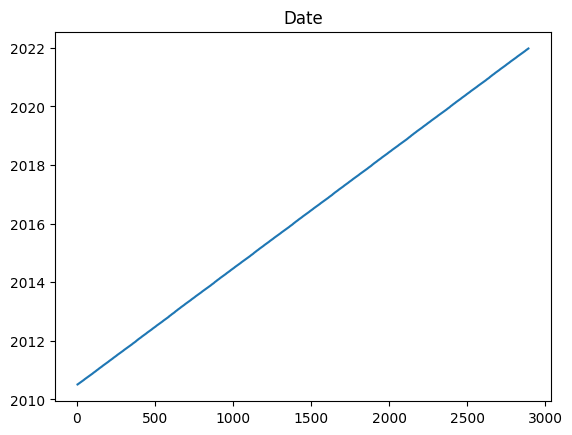

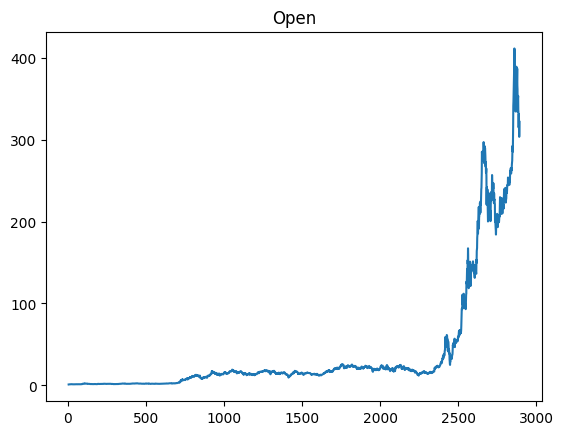

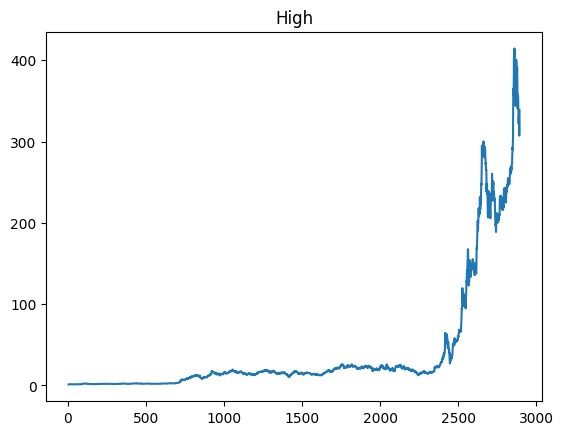

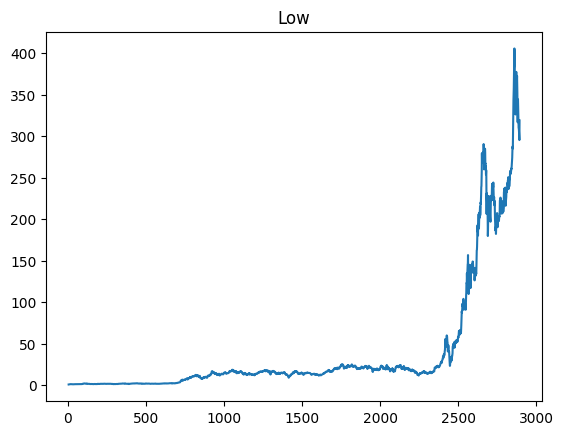

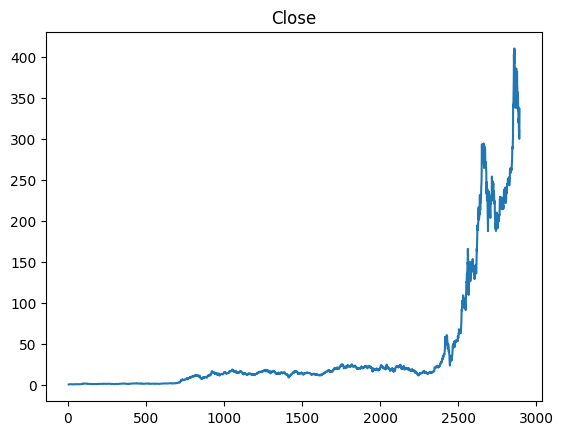

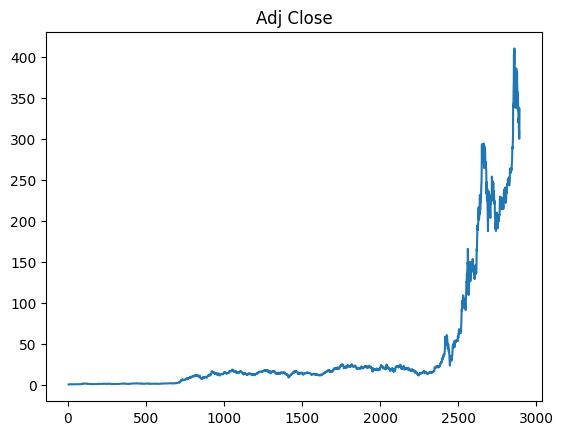

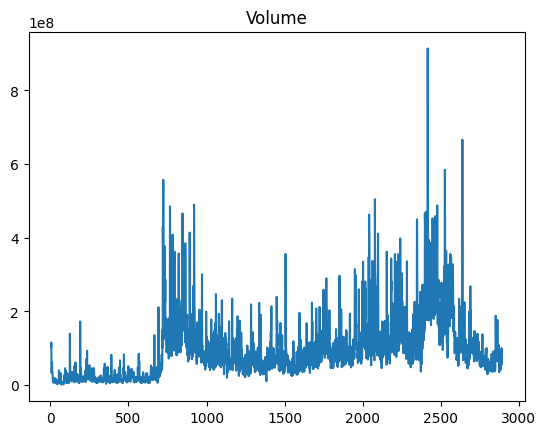

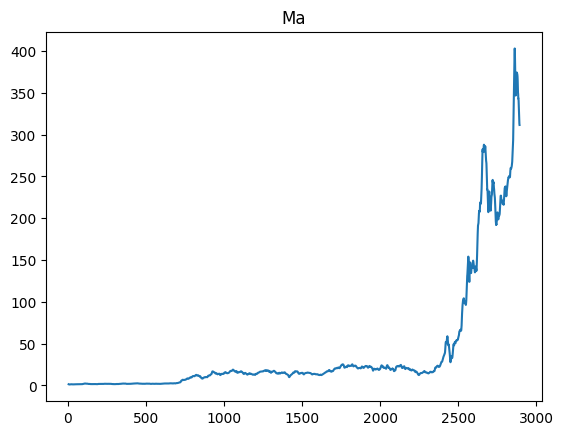

In [9]:
def plot_dataframe(dataframe):

  for column_name in dataframe.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(dataframe[column_name])

plot_dataframe(dataframe)

# Preprocessing

In [10]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    # shape : (n_batch, n_sequence, n_features)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    std[std==0] = 1
    samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
    targets = (targets - mean[:,3:4])/std[:,3:4] # The close value is our target
    return samples, targets

In [11]:
# TimeseriesGenerator Check

data = np.array([[i, i**2,i**3,i**4] for i in range(11)])
targets = np.array([[i**4] for i in range(11)])

print(targets.shape)

mean = data[:-1].mean(axis=0)[None,:]
std = data[:-1].std(axis=0)[None,:]

data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=1,
                               batch_size=2)
batch_0 = data_gen[0]
x, y = batch_0

print(np.array(x*std+mean,dtype = int))
print(y*std[..., 3]+mean[..., 3])

(11, 1)
[[[   0    0    0    0]
  [   1    1    1    1]
  [   2    4    8   16]
  [   3    9   27   81]
  [   4   16   64  256]
  [   5   25  125  625]
  [   6   36  216 1296]
  [   7   49  343 2401]
  [   8   64  512 4096]
  [   9   81  729 6561]]]
[[10000.]]


In [12]:
data.shape

(11, 4)

In [13]:
# Generarate 5 days sequences from all data
# TODO: How to deal with weekend lack of information?

n_sequence = 5
n_batch = 128
n_features = 7

def get_gen_train_test(dataframe):
  data = dataframe.drop(columns='Date').to_numpy()
  targets = data[:,3, None] #add none to have same number of dimensions as data
  #targets = data
  n_samples = data.shape[0]

  train_test_split=int(n_samples*0.9)

  data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
  data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)
  
  return data_gen_train, data_gen_test

In [14]:
# test on data

x_gen, y_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=1)[0]
print(x_gen)
print(y_gen)

x = data[None, :5,:]
mean = x.mean(axis=1)
std = x.std(axis=1)
x = (x - mean)/std
y = (data[5,3] - mean[...,3])/std[...,3]
print(x)
print(y)

assert (x_gen == x).all()
assert y_gen == y

[[[-1.41421356 -1.01709526 -0.83189033 -0.72799757]
  [-0.70710678 -0.84757938 -0.79029581 -0.71771512]
  [ 0.         -0.33903175 -0.4991342  -0.56347834]
  [ 0.70710678  0.50854763  0.29116162  0.10488101]
  [ 1.41421356  1.69515876  1.83015873  1.90431003]]]
[[5.69853465]]
[[[-1.41421356 -1.01709526 -0.83189033 -0.72799757]
  [-0.70710678 -0.84757938 -0.79029581 -0.71771512]
  [ 0.         -0.33903175 -0.4991342  -0.56347834]
  [ 0.70710678  0.50854763  0.29116162  0.10488101]
  [ 1.41421356  1.69515876  1.83015873  1.90431003]]]
[5.69853465]


# Baseline 

In [15]:
# baseline: use previous day as estimation for the next
squared_error = 0
def mean_squared_error(X, lenght = 5):
  squared_error = 0
  for i in range(0, X.shape[0] - lenght):
    x = X[i:i+lenght]
    mean = x.mean()
    std = x.std()
    x = (x - mean)/std
    y = (X[i+lenght] - mean)/std
    squared_error += np.square(x[-1]-y)
  return squared_error/X.shape[0]

baseline_error = mean_squared_error(data[:,3])
baseline_error

3.4528189810500125

In [16]:
data_gen = Standarized_TimeseriesGenerator(data, targets,
                               length=5, sampling_rate=1,
                               stride=1, batch_size=32)

# baseline: use previous day as estimation for the next
def mean_squared_error(dataset):
  mse=0
  for X_batch, y_batch in dataset:
    # X_batch.shape : (n_batch, n_sequence, n_features)
    #mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
    mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch))
  mse /= len(dataset)
  return mse

baseline_error = mean_squared_error(data_gen)
baseline_error 

6.330168131925023

# Utilities

In [17]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true-y_pred))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)/y_true))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:] > y_true[:-1],tf.float32)
    return tf.reduce_mean((y_true[1:]-y_true[:-1])*mask)


#class ar(tf.keras.metrics.Metric):
#  def __init__(self, name="ar", **kwargs):
#    super(ar, self).__init__(name=name, **kwargs)
#    self.y_old = self.add_weight(name='y_old', shape=n_batch, initializer='zeros', dtype=tf.float32)
#    self.y_true = self.add_weight(name='y_true', shape=n_batch, initializer='zeros', dtype=tf.float32)
#    self.y_pred = self.add_weight(name='y_pred', shape=n_batch, initializer='zeros', dtype=tf.float32)

#  def update_state(self, y_true, y_pred, sample_weight = None):
#    self.y_true = y_true[:,3]
#    self.y_pred = y_pred[:,3]
#    # shape y : (batch_size, n_features)
#    self.y_old = tf.stack([self.y_old[-1] , self.y_true[:-1]], 0)

#  def result(self):
#    mask = tf.cast(self.y_pred > self.y_old, tf.float32)
#    return tf.reduce_mean((self.y_true - self.y_old)*mask)

   
  
  

In [18]:
# Metrics not included in keras

# For some reason keras mape is different so it has to be customly defined.
# Paper definition isn't percentual, hence the difference. (x100)
#def mape(y_true, y_pred):
#    return tf.keras.backend.mean(tf.keras.backend.abs((y_true-y_pred)/y_true))
#    # ***The absolute is over the whole thing as y_true can be negative

#def rmse(y_true, y_pred):
#    return tf.sqrt(tf.keras.backend.mean(tf.square(y_true-y_pred)))

#def ar(y_true, y_pred):
#    N = tf.cast(tf.size(y_true), tf.float32)
#    return tf.keras.backend.sum(tf.keras.backend.maximum(y_true-y_pred, 0)) / (N-1)

# ANN

In [19]:
def make_DCBiLSTM_model():
  inputs = Input(shape=(n_sequence, n_features,))
  inputs_flatten = Flatten()(inputs)
  ann_1 = Dense(units=1000, activation='tanh')(inputs_flatten)
  ann_1_droput = Dropout(0.9)(ann_1)
  ann_2 = Dense(units=100, activation='tanh')(ann_1_droput)
  ann_2_droput = Dropout(0.7)(ann_2)
  output_dense = Dense(1, activation=None)(ann_2_droput)
  output = LeakyReLU(alpha=0.3)(output_dense) 


  model = Model(inputs = inputs, outputs = output)
  #model.compile(loss=generator_loss)
  model.compile(loss='mse', metrics = [mse , mae, mape, rmse, ar])
  #model.compile(loss=None, metrics = [mse , mae, mape, rmse])
  model.summary()

  #return model, slice_model
  return model

  #history = model.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
   #                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
  


# Visualization

In [20]:
metrics = ["loss", 'mse','mae','mape','rmse','ar']
def plot_history(history):
  #metrics = ["loss", 'mse','mae','mape','rmse','ar']
  #metrics = ["gen_loss","gen_slice_loss", 'mse','mae','mape','rmae','ar']
  for metric_name in metrics:  
    plt.figure()
    plt.title(metric_name)
    plt.plot(history.history[metric_name], label='train')
    plt.plot(history.history["val_"+metric_name], label='test')
    plt.legend()
  plt.show()

#plot_history(history)

In [21]:
def plot_frame(sequence, target, model):
  sequence, target = data_gen_test[0]
  y_pred = model.predict(sequence)
  y_true = target

  plt.figure()
  plt.title("closing price")
  plt.plot(y_true, label="true")
  plt.plot(y_pred, label="prediction")
  plt.legend()
  plt.show()

#plot_frame(*data_gen_test[0], lstm)

## Test

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 flatten (Flatten)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1000)              36000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101   

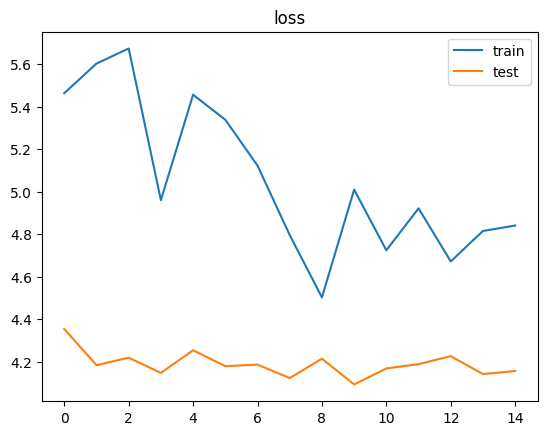

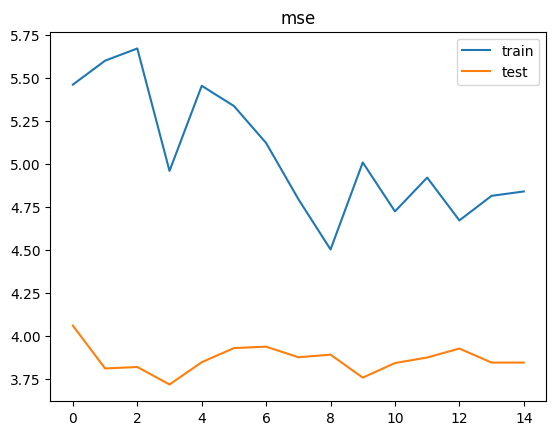

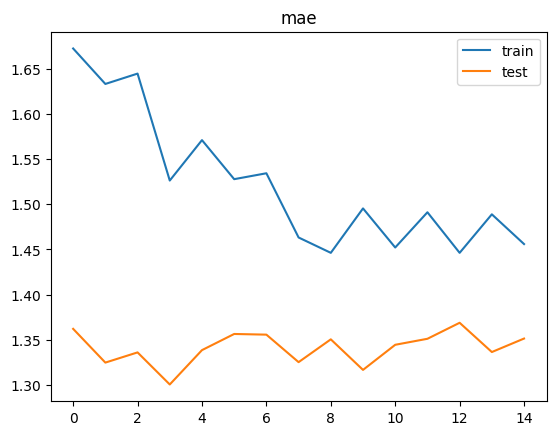

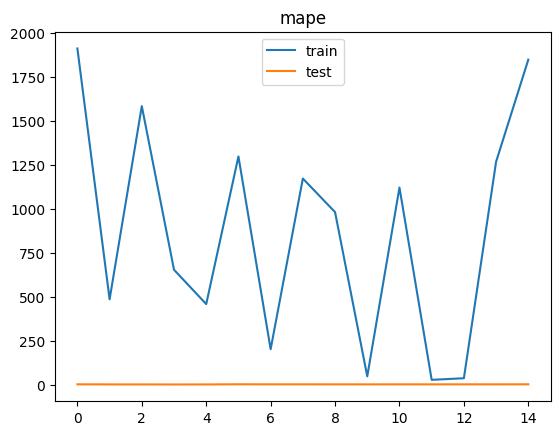

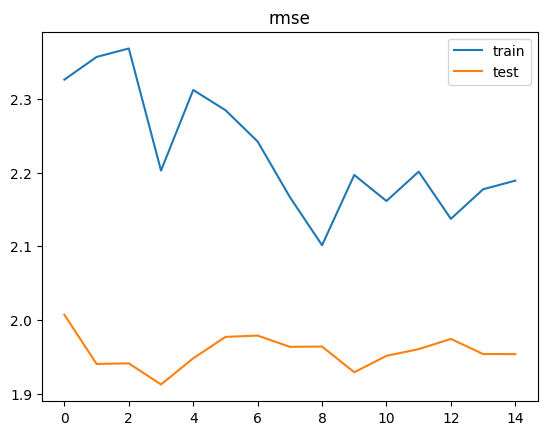

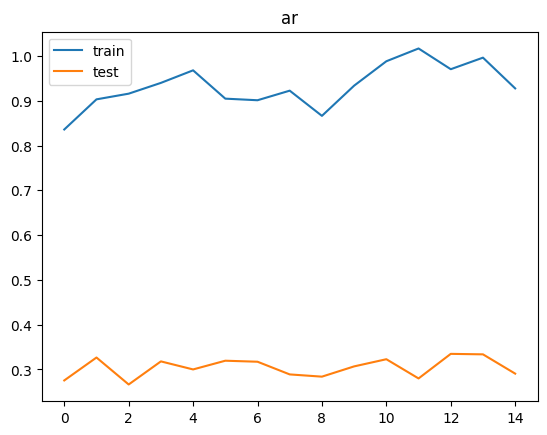

4/4 [==============================] - 0s 2ms/step


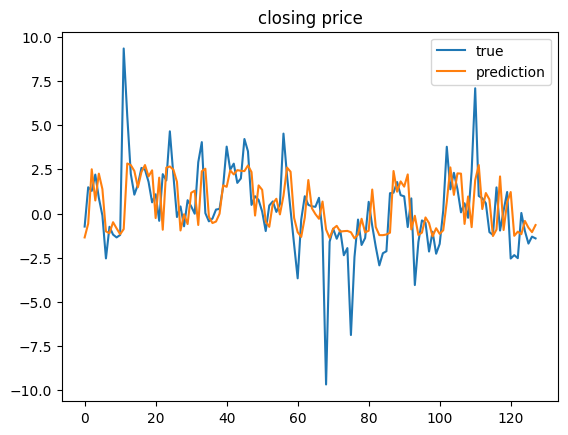

[MSE Baseline] train: 4.590811566455917  test: 3.7440678649972674


In [22]:
dataframe = add_Ma(dataframe)

#plot_dataframe(dataframe)

data_gen_train, data_gen_test = get_gen_train_test(dataframe)

dcbilstm = make_DCBiLSTM_model()
history = dcbilstm.fit(data_gen_train, validation_data=data_gen_test, epochs = 100,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
dcbilstm.save('dcbilstm.h5')
plot_history(history)
plot_frame(*data_gen_test[0], dcbilstm)

print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))